In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.colors import LogNorm

In [2]:
from cosmoHammer.ChainContext import ChainContext
from ClusterCosmologyModules import MassfunctionCoreModule 
from ClusterCosmologyModules import XRayLuminosityLikelihoodModule

In [3]:
from classy import Class

In [4]:
import time as tm

In [5]:
sampling_params = np.array([0.738, 0.0404, 0.25, 0.96, 3, 1.61, 101.483, 1.85, 0.396])
ctx = ChainContext(parent=None, params=sampling_params)

In [6]:
DEFAULT_PARAMS = {'N_ncdm':0, #number of ncdm relics (among which massive neutrinos or WDM)
                  'Omega_k': 0.0,
                  'gamma': 0.55,
                  'w0_fld':-1.,
                  'wa_fld':0.,
                  'DE_perturb': True
                   }

CLASS_OUTPUT_PARAMS = {'output': 'mPk',
                       'P_k_max_h/Mpc': 15.,
                       'z_max_pk': 2.}

COSMOLOGY_PARAMETER_MAPPING = {'h': 0,
                               'Omega_b': 1,
                               'Omega_cdm': 2,
                               'n_s': 3,
                               'ln10^{10}A_s': 4
                               }

CLUSTER_PARAMETER_MAPPING = {'A_LM': 5,
                             'B_LM': 6,
                             'C_LM': 7,
                             'D_LM': 8
                             }

In [7]:
p1 = ctx.getParams()

cosmo_params = DEFAULT_PARAMS.copy() #saving the constants
cosmo_params.update(CLASS_OUTPUT_PARAMS) #appending output parameters

for key, value in COSMOLOGY_PARAMETER_MAPPING.items():
    cosmo_params[key] = p1[value] #adding the relevant cosmological parameters

#popping gamma and setting for modified growth
try:
    gamma = cosmo_params.pop('gamma')
    if gamma!=0.55:
        cosmo_params['z_max_pk']=10.
except KeyError:
    tmp=0

# set up correctly the dark energy density
de_perturb = cosmo_params.pop('DE_perturb')
try:
    if cosmo_params['w0_fld'] == -1. and cosmo_params['wa_fld']==0:
        cosmo_params.pop('w0_fld')
        cosmo_params.pop('wa_fld')
    else:
        if de_perturb:  # include neutrino density here
            cosmo_params['Omega_fld'] = 1.-cosmo_params.pop('Omega_k')-cosmo_params['Omega_b'] \
            -cosmo_params['Omega_cdm']
        else:
            cosmo_params['Omega_Lambda'] = 1.-cosmo_params.pop('Omega_k')-cosmo_params['Omega_b'] \
            -cosmo_params['Omega_cdm']
except KeyError:
    tmp = 0

astro_params = {}
for key, value in CLUSTER_PARAMETER_MAPPING.items():
    astro_params[key] = p1[value] #saving the relevant astrophysical parameters

In [8]:
from ClusterCosmologyModules import converter_Class2Camb

params_class = cosmo_params.copy()
start = tm.time()
params = converter_Class2Camb(params_class)
end = tm.time()
print end-start
print params

0.000128984451294
{'scalar_amp': 2.0085536923187669e-09, 'omegak': 0.0, 'H0': 73.799999999999997, 'omegac': 0.25, 'omegab': 0.040399999999999998, 'scalar_index': 0.95999999999999996, 'omegav': 0.70960000000000001}


In [9]:
import pycamb as pc

k = np.logspace(-5.,1.,num=500)
z = np.linspace(0,2,num=200)

start = tm.time()
olo, Pk_out= pc.matter_power(redshifts=z[::-1], k=k,**params)
Pk = Pk_out[:, ::-1]
end = tm.time()
print end-start
print np.shape(Pk_out)

1.92534279823
(500, 200)


In [34]:
from ClusterCosmologyModules import trapz

In [10]:
cosmology = Class()
cosmology.set(cosmo_params)
cosmology.compute()
print cosmology.sigma8()

cosmo2 = Class()
cosmo2.compute()

0.889884483979


In [11]:
test_massfunction = MassfunctionCoreModule(sel_obs_min=42, sel_obs_max=47, sel_obs_bin=120)
start = tm.time()
test_massfunction.setup()
end = tm.time()
print 'mass function setup time:', end-start
test_massfunction.cosmology = cosmology

mass function setup time: 9.20295715332e-05


In [12]:
np.log10(7.e13) #pilleich mass cut

13.845098040014257

In [13]:
M_arr = np.logspace(13.,16.,test_massfunction.len_sel_obs)*cosmology.pars['h']
M_arr = np.outer(np.ones(test_massfunction.len_z), M_arr)
print np.shape(M_arr)

(200, 120)


In [28]:
start = tm.time()
mPk, sigma8 = test_massfunction.get_MatterPowerspectum_Class()
end = tm.time()
print 'time needed: %f' %(end-start)
print np.shape(mPk)

time needed: 0.601391
(500, 200)


In [39]:
tmp = np.tensordot(k, M_arr, 0)

tmp1 = k[:,None,None]*M_arr[None,:,:]
print np.shape(tmp), np.shape(tmp)
print np.any(tmp1!=tmp)

(500, 200, 120) (500, 200, 120)
False


In [30]:
tmp2 = tmp*k[:,None,None]
print np.shape(tmp2)

tmp2_test = np.empty((500,200,120))
for i in xrange(500):
    tmp2_test[i] = tmp[i]*k[i]
print np.amax(tmp2_test-tmp2), np.amin(tmp2_test-tmp2)

(500, 200, 120)
0.0 0.0


In [33]:
tmp3 = tmp2*mPk[:,:,None]

tmp3_test = np.empty((500,200,120))
for i in xrange(500):
    for j in xrange(200):
        tmp3_test[i,j] = tmp2[i,j]*mPk[i,j]
print np.amax(tmp3_test-tmp3), np.amin(tmp3_test-tmp3)

0.0 0.0


In [36]:
res = trapz(tmp3, k[:,None, None])
print np.shape(res)

(200, 120)


In [15]:
print np.where(test_massfunction.k_arr != k)
print np.shape(mPk)
print (mPk[1]- Pk[1])/mPk[1]
da1 = pc.angular_diameter(z[::-1], **params)[::-1]
da2 = np.array([cosmology.angular_distance(z[i]) for i in xrange(len(z))])
print (da1-da2)/da2

(array([], dtype=int64),)
(500, 200)
[  4.32776687e-05   3.82044680e-05   3.66894148e-05   3.76814834e-05
   3.98665602e-05   4.24262425e-05   4.41543113e-05   4.52761603e-05
   4.59686762e-05   4.58053236e-05   4.53198863e-05   4.44474389e-05
   4.33076313e-05   4.19690053e-05   4.04476680e-05   3.91254317e-05
   3.79224173e-05   3.70048014e-05   3.64448554e-05   3.59847915e-05
   3.56705204e-05   3.54226419e-05   3.53017604e-05   3.51526750e-05
   3.49626726e-05   3.49633920e-05   3.47990671e-05   3.46365183e-05
   3.46183599e-05   3.46663641e-05   3.45429136e-05   3.45499780e-05
   3.44778017e-05   3.43874240e-05   3.42180566e-05   3.40910930e-05
   3.36961308e-05   3.33215318e-05   3.29304308e-05   3.25742324e-05
   3.22898808e-05   3.19906796e-05   3.16823206e-05   3.14560065e-05
   3.13548191e-05   3.12929650e-05   3.11735759e-05   3.11217807e-05
   3.09094060e-05   3.08872757e-05   3.06969227e-05   3.04460343e-05
   3.03661300e-05   3.01402937e-05   2.98739620e-05   2.97391539e-

/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in divide


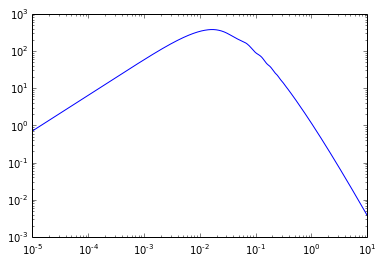

In [16]:
out1, out2 = pc.matter_power([10], k, **params)
plt.figure()
plt.loglog(out1, out2)

In [17]:
start = tm.time()
dndM = test_massfunction.calcMF(M_arr, mPk)
end = tm.time()
print 'time needed: %f' %(end-start)

time needed: 4.672642


In [18]:
start = tm.time()
dV_z = test_massfunction.zVol()
end = tm.time()
print 'time needed: %f' %(end-start)

time needed: 0.000535


In [19]:
dNdM = dndM*dV_z

In [20]:
f_sky = 0.68
dNdM *= 4*np.pi*f_sky

In [21]:
dlogM= np.log10(M_arr)[0,1] - np.log10(M_arr)[0,0]
print dlogM

0.0150753768844


7.33773512822


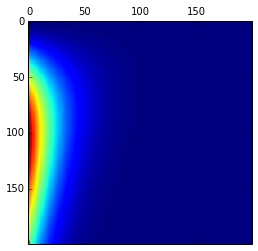

In [22]:
N = dNdM*dlogM
print np.log10(np.sum(N))

plt.figure()
plt.matshow(N)

In [23]:
A_LM = astro_params['A_LM']
B_LM = astro_params['B_LM']
C_LM = astro_params['C_LM']
D_LM = astro_params['D_LM']
h0 = cosmology.pars['h']

def Mass2LX(M, z):
    lnLX = B_LM + 1.5*(D_LM**2-0.396**2) + A_LM*np.log(M/3.9e14) + \
    C_LM*np.log(test_massfunction.E_z(z)) - 0.39*np.log(h0/0.72)

    return lnLX

In [29]:
print np.exp(Mass2LX(3.9e14, 0.))
dz = test_massfunction.z_arr[1] - test_massfunction.z_arr[0]
print dz

1.17307181288e+44
0.0100502512563


In [30]:
Mpc2cm = 3.086e+24
f_cut = 4.4e-14 
L_cut = 1e43
z_mock = []
M_mock = []
LX_mock = []
fX_mock = []
for i in xrange(test_massfunction.len_z):
    z = test_massfunction.z_arr[i]
    for j in xrange(test_massfunction.len_sel_obs):
        M = M_arr[i,j]/cosmology.pars['h']
        Num = np.random.poisson(N[i,j])
        for k in xrange(Num):
            zi = z + dz*np.random.rand()
            lnLX = D_LM*np.random.randn()+Mass2LX(M,zi)
            LX = np.exp(lnLX)
            #z_mock.append(z)
            #M_mock.append(M)
            #LX_mock.append(LX)
            
            DL = cosmology.luminosity_distance(zi)*Mpc2cm
            if DL!=0:
                fX = LX/(4*np.pi*DL**2)
                if fX>f_cut and LX>L_cut:
                    z_mock.append(zi)
                    M_mock.append(M)
                    LX_mock.append(LX)
                    fX_mock.append(fX)

143456 5.15671871719
4.45975307398e+45 1.00004619443e+43


<matplotlib.colorbar.Colorbar instance at 0x106b2bb00>

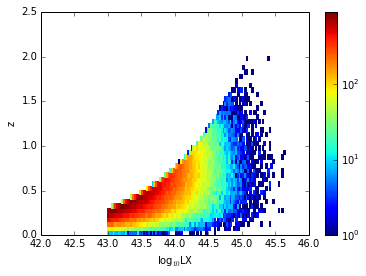

In [31]:
H, xe, ye = np.histogram2d(np.log10(LX_mock), z_mock, bins=(100,40))

H = np.rot90(H)
H = np.flipud(H)

Hmasked = np.ma.masked_where(H==0,H)

print len(LX_mock), np.log10(len(LX_mock))
print np.amax(LX_mock), np.amin(LX_mock)

plt.figure()
plt.pcolormesh(xe, ye, Hmasked, edgecolors='None',norm=LogNorm())
plt.xlabel('log$_{10}$LX')
plt.ylabel('z')
plt.xlim([42,46])
plt.colorbar()

143456 5.15671871719
1.95473963807e-08 4.40000990929e-14


<matplotlib.colorbar.Colorbar instance at 0x107bd1680>

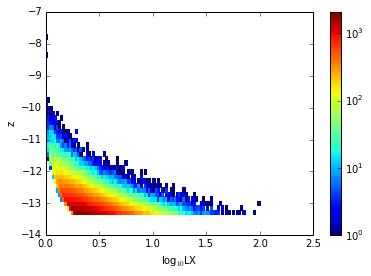

In [32]:
H, xe, ye = np.histogram2d(z_mock, np.log10(fX_mock), bins=(100,40))

H = np.rot90(H)
H = np.flipud(H)

Hmasked = np.ma.masked_where(H==0,H)

print len(fX_mock), np.log10(len(fX_mock))
print np.amax(fX_mock), np.amin(fX_mock)

plt.figure()
plt.pcolormesh(xe, ye, Hmasked, edgecolors='None',norm=LogNorm())
plt.xlabel('log$_{10}$LX')
plt.ylabel('z')
plt.colorbar()

In [60]:
print np.amax(M_mock), np.amin(M_mock)
print np.amax(z_mock), np.amin(z_mock)

2.35428641432e+15 3.16227766017e+13
1.93969849246 0.0100502512563


In [61]:
catalog = np.array([z_mock, M_mock, LX_mock, fX_mock])
print np.shape(catalog)

(4, 145938)


In [62]:
np.savetxt('Mock_flux_lim.txt', catalog)

In [63]:
z, LX = np.genfromtxt('Mock_flux_lim.txt')[[0, 2]]

In [64]:
d1, d2 = test[[0,3]]
plt.figure()
d = plt.hist2d(d1, np.log10(d2), bins=(40, 100))

NameError: name 'test' is not defined

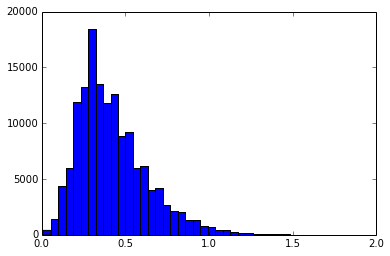

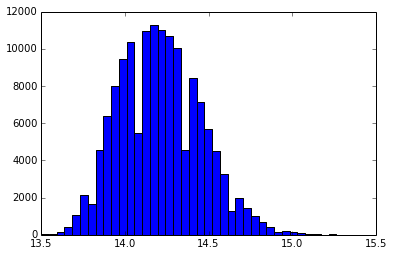

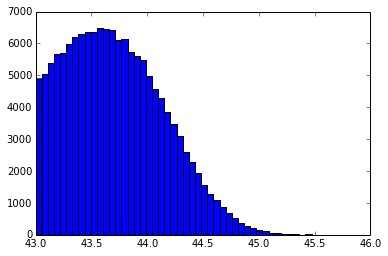

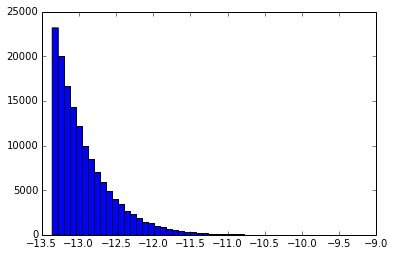

In [38]:
plt.figure()
d = plt.hist(test[0], bins=43)

plt.figure()
d = plt.hist(np.log10(test[1]), bins=43)

plt.figure()
d = plt.hist(np.log10(test[2]), bins=50)

plt.figure()
d = plt.hist(np.log10(test[3]), bins=50)